# Non-Vertex-Transitive 1-WL-Equivalent Graph Pairs + BREC Benchmark

**Dataset of 89 non-isomorphic 1-WL-equivalent graph pairs** for evaluating NDS (Nonlinear Diffusion Signatures) expressiveness beyond the Weisfeiler-Lehman hierarchy.

Contains 2 datasets:
1. **BREC_Basic** — 60 non-vertex-transitive, non-regular pairs from the BREC benchmark with varying scalar node features (degree, clustering, betweenness)
2. **Custom_CFI** — 29 CFI-constructed pairs from diverse base graphs (cycles, paths, Petersen, wheels, etc.) with 24–168 nodes

Each example includes edge lists, node features, adjacency matrices (for small graphs), and rich metadata. All pairs are verified non-isomorphic and 1-WL-equivalent.

This notebook loads a mini subset, converts raw records into the output schema, and visualizes graph properties.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# networkx — pre-installed on Colab, install locally to match Colab env
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'matplotlib==3.10.0', 'networkx==3.6.1')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path

## Data Loading

Load the mini demo dataset from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-7ff1bb-nonlinear-diffusion-signatures-breaking-/main/dataset_iter4_non_vertex_tran/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} datasets:")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 2 datasets:
  BREC_Basic: 2 examples
  Custom_CFI: 1 examples


## Configuration

Tunable parameters for the demo. These control how many examples to process and display.

In [5]:
# --- Config ---
# Maximum examples to process per dataset
MAX_EXAMPLES_PER_DATASET = 3

# Datasets to include in processing
SELECTED_DATASETS = {"BREC_Basic", "Custom_CFI"}

# Dataset grouping rules (maps category -> dataset name)
DATASET_MAP = {
    "Basic": "BREC_Basic",
    "Custom_CFI": "Custom_CFI",
}

# Dataset ordering for output
DATASET_ORDER = ["BREC_Basic", "Custom_CFI"]

## Processing Examples

Parse the embedded JSON strings in each example to extract graph structures and properties. The `input` and `output` fields are JSON-encoded strings containing the graph data and expected labels.

In [6]:
# Parse each example's JSON-encoded input/output fields and collect statistics
all_examples = []
for ds in data["datasets"]:
    ds_name = ds["dataset"]
    if ds_name not in SELECTED_DATASETS:
        continue
    for ex in ds["examples"][:MAX_EXAMPLES_PER_DATASET]:
        inp = json.loads(ex["input"])
        out = json.loads(ex["output"])
        all_examples.append({
            "dataset": ds_name,
            "pair_id": inp["pair_id"],
            "graph_1": inp["graph_1"],
            "graph_2": inp["graph_2"],
            "is_isomorphic": out["is_isomorphic"],
            "is_1wl_equivalent": out["is_1wl_equivalent"],
            "wl_level": out["wl_equivalence_level"],
            "num_nodes_g1": ex["metadata_num_nodes_g1"],
            "num_nodes_g2": ex["metadata_num_nodes_g2"],
            "num_edges_g1": ex["metadata_num_edges_g1"],
            "num_edges_g2": ex["metadata_num_edges_g2"],
            "vertex_transitive_g1": ex["metadata_graph_1_vertex_transitive"],
            "vertex_transitive_g2": ex["metadata_graph_2_vertex_transitive"],
            "features_vary_g1": ex["metadata_graph_1_features_vary"],
            "features_vary_g2": ex["metadata_graph_2_features_vary"],
            "is_regular_g1": ex["metadata_graph_1_is_regular"],
            "is_regular_g2": ex["metadata_graph_2_is_regular"],
        })

print(f"Parsed {len(all_examples)} examples total")
for ex in all_examples:
    print(f"  {ex['pair_id']}: {ex['num_nodes_g1']} nodes, "
          f"{ex['num_edges_g1']} edges, 1-WL={ex['is_1wl_equivalent']}, "
          f"iso={ex['is_isomorphic']}")

Parsed 3 examples total
  brec_basic_000: 10 nodes, 26 edges, 1-WL=True, iso=False
  brec_basic_001: 10 nodes, 38 edges, 1-WL=True, iso=False
  custom_cfi_cycle_5: 30 nodes, 30 edges, 1-WL=True, iso=False


## Record Conversion (from `data.py`)

The original `record_to_example()` function converts raw graph pair records into the schema-compliant format. Below is the function for reference — the loaded data has already been through this conversion.

In [7]:
def record_to_example(record: dict, idx: int) -> dict:
    """Convert one graph pair record into schema-compliant example.
    
    This is the original function from data.py. It takes raw records
    (with nested input/output/metadata dicts) and produces flat examples
    with JSON-encoded input/output strings and metadata_ prefixed fields.
    """
    inp = record["input"]
    out = record["output"]
    meta = record["metadata"]

    # Build input: JSON string of graph pair data
    input_data = {
        "pair_id": inp["pair_id"],
        "graph_1": {
            "num_nodes": inp["graph_1"]["num_nodes"],
            "edge_list": inp["graph_1"]["edge_list"],
            "node_features": inp["graph_1"]["node_features"],
        },
        "graph_2": {
            "num_nodes": inp["graph_2"]["num_nodes"],
            "edge_list": inp["graph_2"]["edge_list"],
            "node_features": inp["graph_2"]["node_features"],
        },
    }
    # Include adjacency matrices only for small graphs (<=50 nodes)
    if "adjacency_matrix" in inp["graph_1"]:
        input_data["graph_1"]["adjacency_matrix"] = inp["graph_1"]["adjacency_matrix"]
    if "adjacency_matrix" in inp["graph_2"]:
        input_data["graph_2"]["adjacency_matrix"] = inp["graph_2"]["adjacency_matrix"]

    # Build output: JSON string of expected properties
    output_data = {
        "is_isomorphic": out["is_isomorphic"],
        "is_1wl_equivalent": out["is_1wl_equivalent"],
        "wl_equivalence_level": out["wl_equivalence_level"],
    }

    example = {
        "input": json.dumps(input_data, separators=(",", ":")),
        "output": json.dumps(output_data, separators=(",", ":")),
        "metadata_fold": 0,
        "metadata_pair_id": inp["pair_id"],
        "metadata_category": meta["category"],
        "metadata_difficulty": meta["difficulty"],
        "metadata_source": meta["source"],
        "metadata_task_type": "graph_pair_classification",
        "metadata_graph_1_vertex_transitive": meta["graph_1_vertex_transitive"],
        "metadata_graph_2_vertex_transitive": meta["graph_2_vertex_transitive"],
        "metadata_graph_1_features_vary": meta["graph_1_features_vary"],
        "metadata_graph_2_features_vary": meta["graph_2_features_vary"],
        "metadata_graph_1_is_regular": meta["graph_1_is_regular"],
        "metadata_graph_2_is_regular": meta["graph_2_is_regular"],
        "metadata_num_nodes_g1": meta["num_nodes_g1"],
        "metadata_num_nodes_g2": meta["num_nodes_g2"],
        "metadata_num_edges_g1": meta["num_edges_g1"],
        "metadata_num_edges_g2": meta["num_edges_g2"],
        "metadata_row_index": idx,
    }

    # Add optional metadata
    if "brec_pair_index" in meta:
        example["metadata_brec_pair_index"] = meta["brec_pair_index"]
    if "base_graph" in meta:
        example["metadata_base_graph"] = meta["base_graph"]
    if "graph6_g1" in meta:
        example["metadata_graph6_g1"] = meta["graph6_g1"]
    if "graph6_g2" in meta:
        example["metadata_graph6_g2"] = meta["graph6_g2"]

    return example

print("record_to_example() defined — original conversion function from data.py")

record_to_example() defined — original conversion function from data.py


## Dataset Grouping (from `data.py`)

The original pipeline groups records by category and filters to only the selected datasets. Here we replicate this logic on the already-processed data to show how the grouping works.

In [8]:
# Group examples by dataset and build output structure (mirrors main() in data.py)
groups = {}
skipped = 0
for idx, ex in enumerate(all_examples):
    category = ex["dataset"]
    dataset_name = DATASET_MAP.get(category, category)
    if dataset_name not in SELECTED_DATASETS:
        skipped += 1
        continue
    if dataset_name not in groups:
        groups[dataset_name] = []
    groups[dataset_name].append(ex)

print(f"Skipped {skipped} examples from non-selected categories")

# Build output in consistent order
datasets_out = []
for ds_name in DATASET_ORDER:
    if ds_name in groups:
        examples = groups[ds_name]
        datasets_out.append({"dataset": ds_name, "examples": examples})
        print(f"  {ds_name}: {len(examples)} examples")

output = {"datasets": datasets_out}
total = sum(len(ds["examples"]) for ds in datasets_out)
print(f"\nTotal: {total} examples across {len(datasets_out)} datasets")

Skipped 0 examples from non-selected categories
  BREC_Basic: 2 examples
  Custom_CFI: 1 examples

Total: 3 examples across 2 datasets


## Results Summary

Display key properties of each graph pair in a readable table.

In [9]:
# Print summary table
header = f"{'Pair ID':<25} {'Dataset':<12} {'Nodes':>5} {'Edges':>5} {'VT':>4} {'Reg':>4} {'Feat':>5}"
print(header)
print("-" * len(header))
for ex in all_examples:
    vt = "Y" if ex["vertex_transitive_g1"] else "N"
    reg = "Y" if ex["is_regular_g1"] else "N"
    feat = "Y" if ex["features_vary_g1"] else "N"
    print(f"{ex['pair_id']:<25} {ex['dataset']:<12} {ex['num_nodes_g1']:>5} "
          f"{ex['num_edges_g1']:>5} {vt:>4} {reg:>4} {feat:>5}")
print()
print("VT = vertex-transitive | Reg = regular | Feat = features vary")

Pair ID                   Dataset      Nodes Edges   VT  Reg  Feat
------------------------------------------------------------------
brec_basic_000            BREC_Basic      10    26    N    N     Y
brec_basic_001            BREC_Basic      10    38    N    N     Y
custom_cfi_cycle_5        Custom_CFI      30    30    Y    Y     N

VT = vertex-transitive | Reg = regular | Feat = features vary


## Visualization

Visualize graph pairs side-by-side, coloring nodes by degree. Each row shows a non-isomorphic pair that is indistinguishable by the 1-WL test.

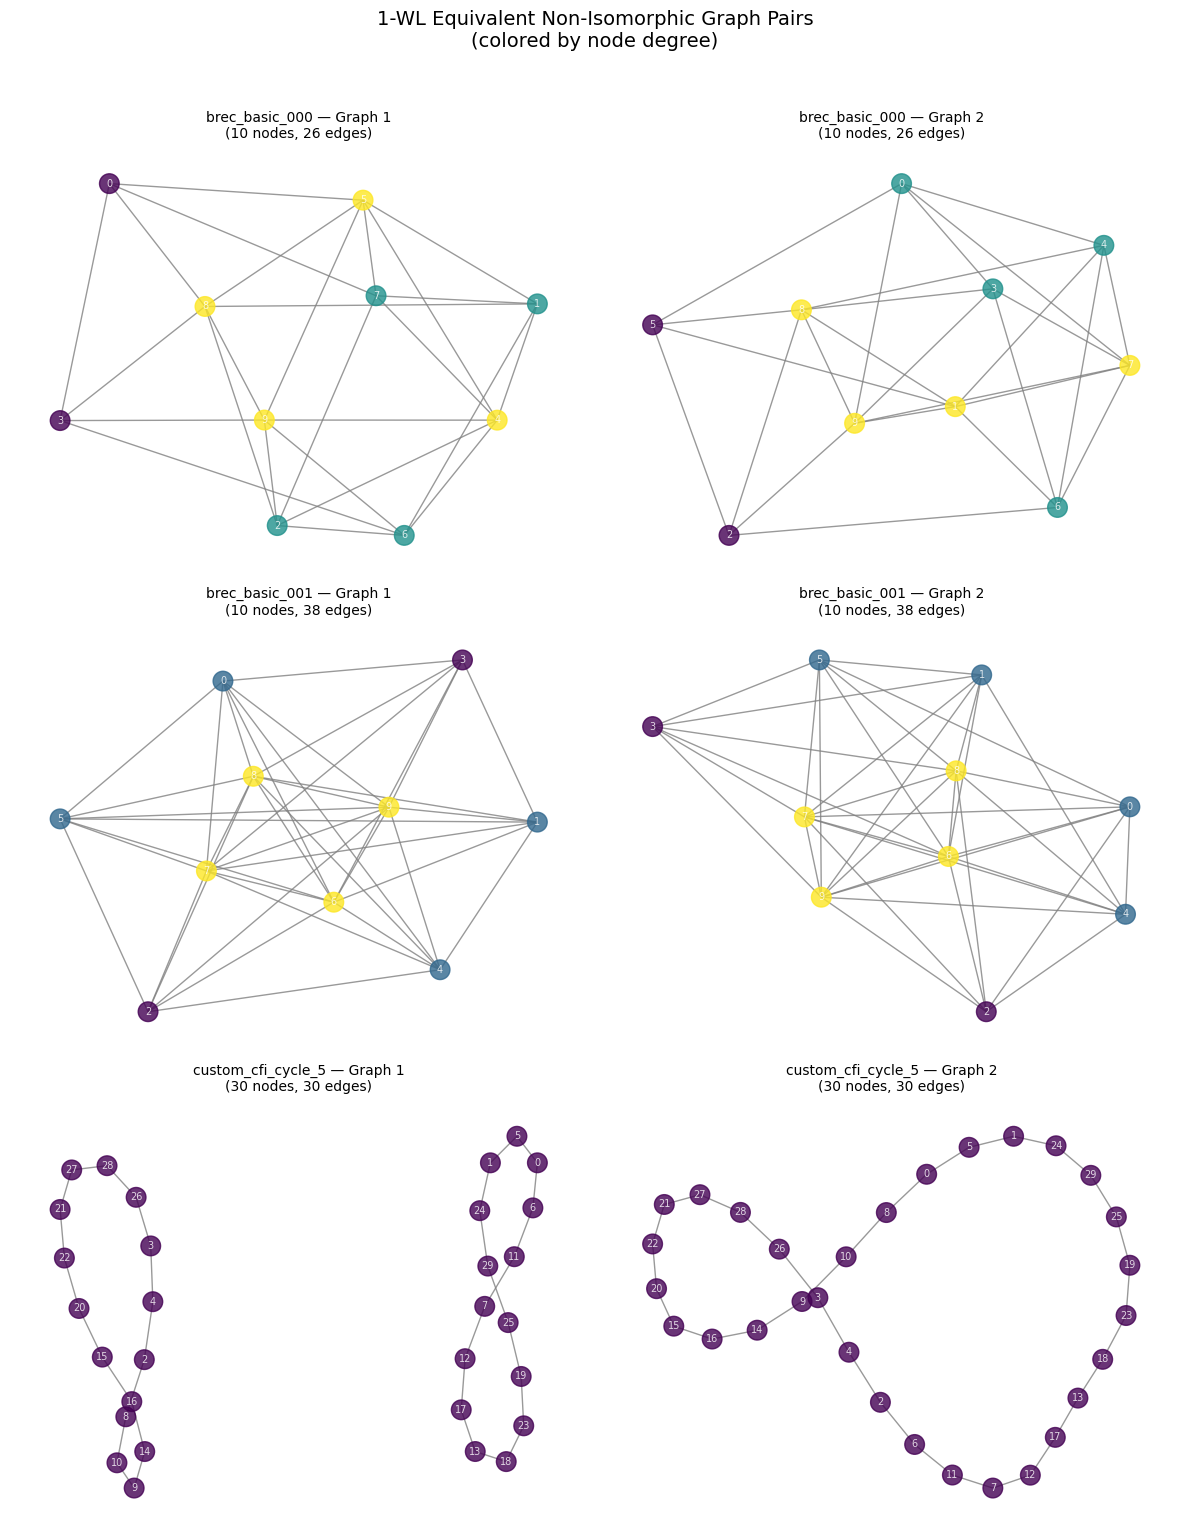

In [10]:
def build_graph(graph_data):
    """Build a networkx graph from edge list and node features."""
    G = nx.Graph()
    G.add_nodes_from(range(graph_data["num_nodes"]))
    G.add_edges_from(graph_data["edge_list"])
    return G

# Plot graph pairs side-by-side
n_pairs = len(all_examples)
fig, axes = plt.subplots(n_pairs, 2, figsize=(12, 5 * n_pairs))
if n_pairs == 1:
    axes = axes.reshape(1, 2)

for i, ex in enumerate(all_examples):
    for j, (gkey, label) in enumerate([("graph_1", "Graph 1"), ("graph_2", "Graph 2")]):
        ax = axes[i, j]
        G = build_graph(ex[gkey])
        degrees = [G.degree(n) for n in G.nodes()]

        pos = nx.spring_layout(G, seed=42)
        nx.draw(
            G, pos, ax=ax,
            node_color=degrees,
            cmap=plt.cm.viridis,
            node_size=200,
            edge_color="gray",
            alpha=0.8,
            with_labels=True,
            font_size=7,
            font_color="white",
        )
        n_key = "num_nodes_g1" if j == 0 else "num_nodes_g2"
        e_key = "num_edges_g1" if j == 0 else "num_edges_g2"
        ax.set_title(
            f"{ex['pair_id']} — {label}\n"
            f"({ex[n_key]} nodes, {ex[e_key]} edges)",
            fontsize=10,
        )

plt.suptitle(
    "1-WL Equivalent Non-Isomorphic Graph Pairs\n(colored by node degree)",
    fontsize=14, y=1.02,
)
plt.tight_layout()
plt.show()

## Node Feature Comparison

Compare node feature distributions (degree, clustering coefficient, betweenness centrality) between graph pairs. These features are key to understanding why 1-WL cannot distinguish the pairs.

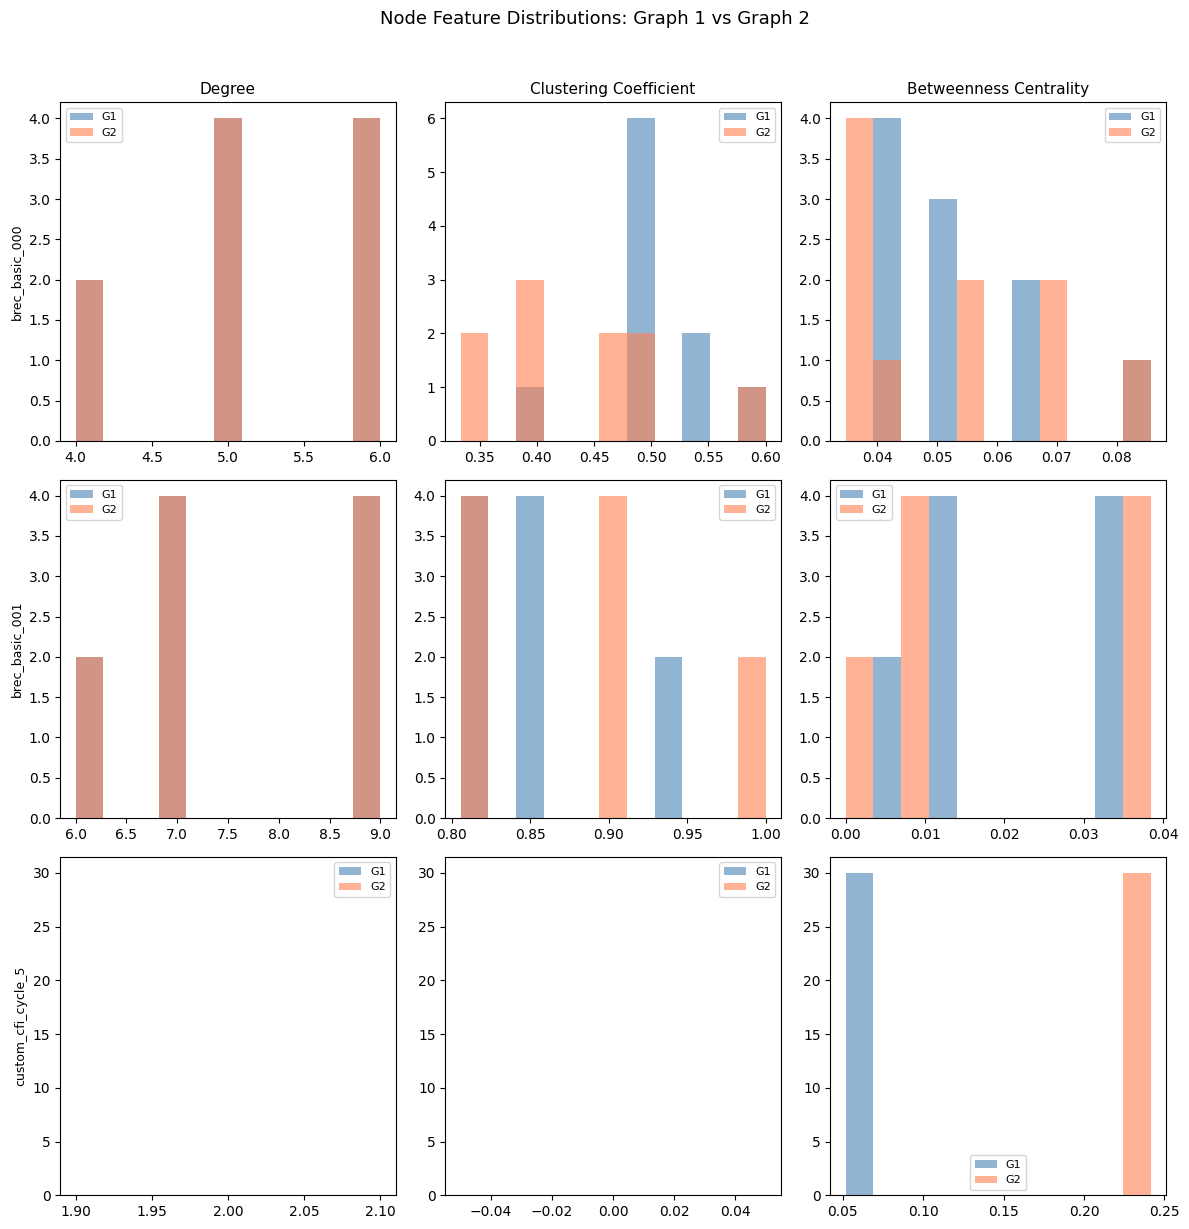


All pairs are non-isomorphic yet 1-WL equivalent —
identical multisets of degree/clustering/betweenness despite different structures.


In [11]:
# Compare node feature distributions for each pair
feature_names = ["degree", "clustering_coefficient", "betweenness_centrality"]
n_features = len(feature_names)

fig, axes = plt.subplots(n_pairs, n_features, figsize=(4 * n_features, 4 * n_pairs))
if n_pairs == 1:
    axes = axes.reshape(1, -1)

for i, ex in enumerate(all_examples):
    for k, feat in enumerate(feature_names):
        ax = axes[i, k]
        g1_feats = ex["graph_1"]["node_features"].get(feat, [])
        g2_feats = ex["graph_2"]["node_features"].get(feat, [])

        if g1_feats and g2_feats:
            bins = np.linspace(
                min(min(g1_feats), min(g2_feats)),
                max(max(g1_feats), max(g2_feats)),
                12,
            )
            ax.hist(g1_feats, bins=bins, alpha=0.6, label="G1", color="steelblue")
            ax.hist(g2_feats, bins=bins, alpha=0.6, label="G2", color="coral")
            ax.legend(fontsize=8)
        else:
            ax.text(0.5, 0.5, "N/A", ha="center", va="center", transform=ax.transAxes)

        short_feat = feat.replace("_", " ").title()
        if i == 0:
            ax.set_title(short_feat, fontsize=11)
        if k == 0:
            ax.set_ylabel(ex["pair_id"], fontsize=9)

plt.suptitle(
    "Node Feature Distributions: Graph 1 vs Graph 2",
    fontsize=13, y=1.02,
)
plt.tight_layout()
plt.show()

print("\nAll pairs are non-isomorphic yet 1-WL equivalent —")
print("identical multisets of degree/clustering/betweenness despite different structures.")